In [1]:
import pandas as pd
import scipy as sp
import sys

In [2]:
asb_input='POLR2A.asb'
vcf_input = 'NA12878_TSS2k_hg38.vcf'
kinetics_input = '/mnt/pan/Data14/1kgp/NA12878/NA12878_pb.est'

asb = pd.read_csv(asb_input, header=0,index_col=0)
vcf = pd.read_csv(vcf_input, comment='#', header=None, sep="\t",usecols=list(range(6)) + [9,13],
                names=['chr','pos','ID','ref','alt','qual','genotype','gene'])                     
kinetics = pd.read_csv(kinetics_input, header=0,index_col=0)

kinetics[['gene','allele']] = kinetics.index.to_series().str.split('-', n=1, expand=True)
kinetics['burst size'] = kinetics['ksyn']/kinetics['koff']
kinetics['burst frequency'] = kinetics['kon'] * kinetics['koff'] / (kinetics['kon'] + kinetics['koff'])

In [3]:
print(asb.head())
print(vcf.head())
print(kinetics.head())

                  ID  CHROM       POS REF ALT  REF.counts  ALT.counts  \
61    1:16896254:C:G   chr1  16896254   C   G          54           2   
63    1:16905229:A:G   chr1  16905229   A   G          51           6   
141   1:44721658:G:A   chr1  44721658   G   A          47           8   
186  10:14185503:G:A  chr10  14185503   G   A          10           1   
190  10:14185809:A:G  chr10  14185809   A   G          33          11   

     Total.counts        AR    RMbias  RAF  Bayes_lower  Bayes_upper  \
61             56  0.964286  0.533178  0.5     0.877597     0.987270   
63             57  0.894737  0.553132  0.5     0.784118     0.947259   
141            55  0.854545  0.530995  0.5     0.736380     0.917791   
186            11  0.909091  0.530995  0.5     0.622747     0.975878   
190            44  0.750000  0.553132  0.5     0.605699     0.851488   

     Corrected.AR  isASB  POLR2A  
61       0.932433   True  POLR2A  
63       0.865689   True  POLR2A  
141      0.827086   Tru

In [4]:
def pref(x):
    if   (x['AR'] > 0.5) & (x['genotype'] == '1|0'):
        return 0
    elif (x['AR'] > 0.5) & (x['genotype'] == '0|1'):
        return 1
    elif (x['AR'] < 0.5) & (x['genotype'] == '1|0'):
        return 1
    elif (x['AR'] < 0.5) & (x['genotype'] == '0|1'):
        return 0

asb_w_genotype = pd.merge(asb,vcf,on='ID')
asb_w_genotype['maternal_allele'] = asb_w_genotype.apply(pref, axis=1)
asb_w_genotype['paternal_allele'] =  1 - asb_w_genotype['maternal_allele']

In [5]:
print(asb_w_genotype.head())

                 ID  CHROM        POS REF ALT  REF.counts  ALT.counts  \
0    1:16905229:A:G   chr1   16905229   A   G          51           6   
1   10:45727276:C:G  chr10   45727276   C   G          14           1   
2  12:104986374:A:C  chr12  104986374   A   C          14           3   
3  12:104986374:A:C  chr12  104986374   A   C           7           1   
4   15:65300564:T:C  chr15   65300564   T   C          25           1   

   Total.counts        AR    RMbias  ...  POLR2A  chr        pos  ref  alt  \
0            57  0.894737  0.553132  ...  POLR2A    1   16905229    A    G   
1            15  0.933333  0.533178  ...  POLR2A   10   45727276    C    G   
2            17  0.823529  0.533178  ...  POLR2A   12  104986374    A    C   
3             8  0.875000  0.820999  ...  POLR2A   12  104986374    A    C   
4            26  0.961538  0.533483  ...  POLR2A   15   65300564    T    C   

  qual  genotype             gene maternal_allele paternal_allele  
0    .       1|0  ENSG00

In [6]:
asb_w_genotype_reform = pd.melt(asb_w_genotype,id_vars=['ID','gene'], \
                            value_vars=['maternal_allele','paternal_allele'], var_name='allele',value_name='pref')
print(asb_w_genotype_reform.head())

                 ID             gene           allele  pref
0    1:16905229:A:G  ENSG00000272426  maternal_allele     0
1   10:45727276:C:G  ENSG00000172661  maternal_allele     1
2  12:104986374:A:C  ENSG00000151131  maternal_allele     0
3  12:104986374:A:C  ENSG00000151131  maternal_allele     0
4   15:65300564:T:C  ENSG00000138617  maternal_allele     1


In [7]:
asb_w_kinetics = pd.merge(asb_w_genotype_reform, kinetics,on=['gene','allele'])
print(asb_w_kinetics)

                  ID             gene           allele  pref       kon  \
0    10:45727276:C:G  ENSG00000172661  maternal_allele     1  33.17614   
1   12:104986374:A:C  ENSG00000151131  maternal_allele     0   2.50532   
2   12:104986374:A:C  ENSG00000151131  maternal_allele     0   2.50532   
3    15:65300564:T:C  ENSG00000138617  maternal_allele     1  19.01498   
4    19:54200892:A:C  ENSG00000170889  maternal_allele     0   0.75376   
..               ...              ...              ...   ...       ...   
95    7:56064217:C:G  ENSG00000129103  paternal_allele     1   0.11448   
96    7:73578528:C:G  ENSG00000106638  paternal_allele     1   0.04461   
97   8:102864097:G:A  ENSG00000253320  paternal_allele     1   0.00100   
98    8:33484993:C:A  ENSG00000198042  paternal_allele     1   0.47681   
99    9:98056788:T:G  ENSG00000095380  paternal_allele     0   0.13112   

          koff        ksyn     n      mean         var  burst size  \
0    190.03491     1.00000  7145   0.1485

/home/bxj139/.usr/local/python/3.7.0/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/bxj139/.usr/local/python/3.7.0/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/bxj139/.usr/local/python/3.7.0/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/bxj139/.usr/local/python/3.7.0/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/bxj139/.usr/local/python/3.7.0/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


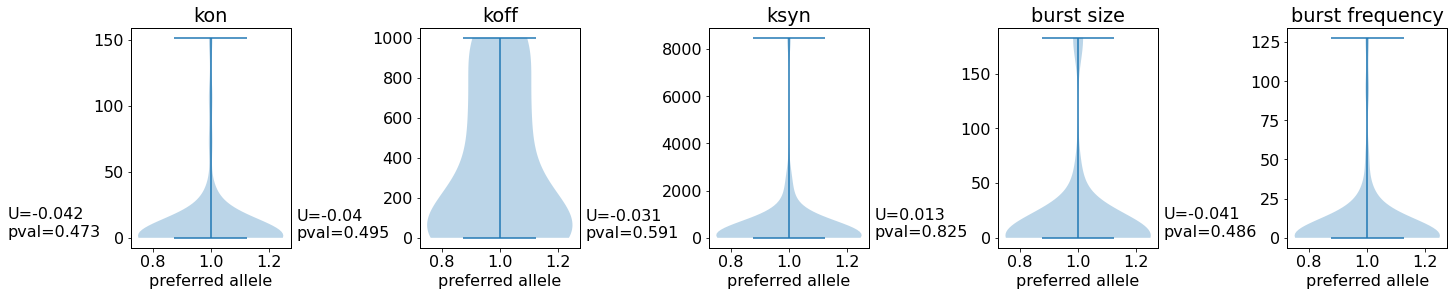

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
import pingouin as pg
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1

kp=['kon','koff','ksyn','burst size','burst frequency']
nfig=len(kp)
fig,ax = plt.subplots(ncols=nfig, sharex=True,constrained_layout=True,figsize=(4*nfig, 4))
for i, ikp in enumerate(kp):
    x  = [0,1]
    y0 = asb_w_kinetics.loc[asb_w_kinetics['pref']==0,ikp]
    y1 = asb_w_kinetics.loc[asb_w_kinetics['pref']==1,ikp]

    res = pg.mwu(y1, y0)
    pval = round(res.loc['MWU','p-val'],3)
    es   = round(res.loc['MWU','CLES']-0.5, 3)
    
    ax[i].violinplot([y0,y1],x)
    ax[i].set_title(ikp)
    ax[i].set_xlabel('preferred allele')
    ax[i].text(0.3, 1,'U=%s\npval=%s'%(es, pval))
plt.savefig(asb_input + 'tss2k' + '.pdf')